# Gaussian process surrogate modelling 

## One-dimensional GP regression
### Generating training data

Below we generate a noiseless training data set for $f(x) = \sin(x)$, specifically $f$ at uniform grid on $[0,L]$.

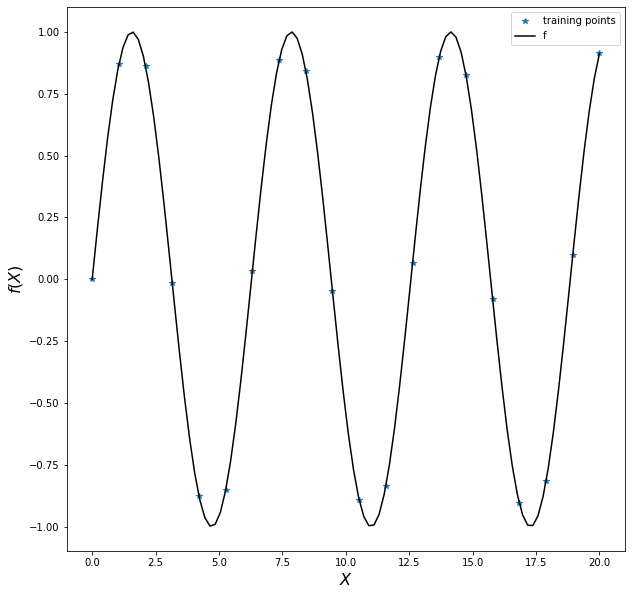

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

# Generate noiseless training data where underlying f is sine.
N_train = 20
L = 20
#X_train = np.zeros([N_train, D])
X_train = np.linspace(0, L, N_train)

Y_train = np.sin(X_train)


# Plot training data
fig, ax = subplots(1, 1, figsize = (10, 10))
ax.plot(X_train, Y_train, '*', label = 'training points')
ax.plot(np.linspace(0, L, 100), np.sin(np.linspace(0, L, 100)), 'k-', label = 'f')
ax.set_xlabel(r'$X$', fontsize = 16)
ax.set_ylabel(r'$f(X)$', fontsize = 16)
ax.legend(loc = 'best')
plt.show()

### Fitting a GP through test points

Below we choose a set of x-values, $\textbf{X}^{*}$, for which we will generate random approximations of $f(\textbf{X}^{*})$, based on a Gaussian process fitted to the training data created above.

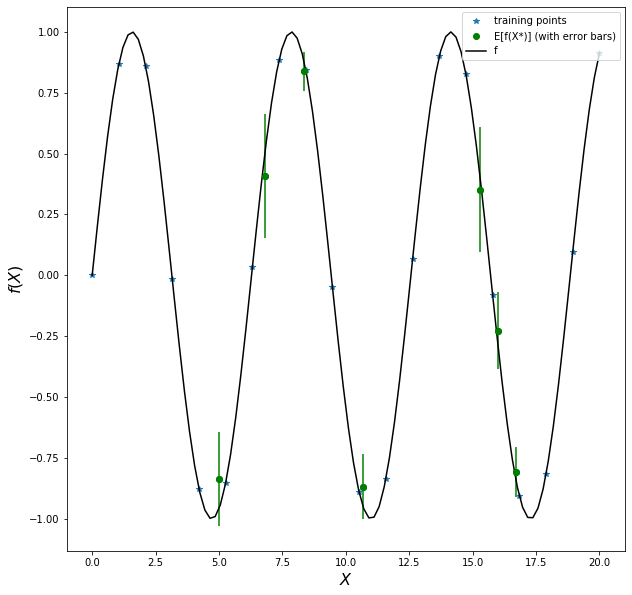

Condition number of k =  14.158308594318664
X* =  [16.72621349 10.6866554   8.33324785 15.98684705 15.27137175  6.79810527
  5.00127803]
E[f(X*)] =  [-0.80738729 -0.86801188  0.83802482 -0.22771585  0.35253539  0.40798144
 -0.83650785]
V(f(X*)) =  [0.10221948 0.13433247 0.0799242  0.15816198 0.25718561 0.2554896
 0.19341679]
True f(X*) =  [-0.85119094 -0.95266282  0.88733353 -0.27528273  0.42285317  0.49246519
 -0.95856096]


In [67]:
### Choosing X* for which I want to approximate f(X*).

#X_star = np.array((3.2, 6.2, 12.5, 15.5))
N_star = 7
X_star = L * np.random.rand(N_star)
#N_star = X_star.shape[0]

### Constructing covariance matrix, K, with elements given by k(x_1,x_2), the 'squared exponential' cov kernel.
X = np.concatenate((X_train, X_star))
#cov = lambda x_1, x_2: np.exp(-0.5 * np.transpose(x_1 - x_2) * (x_1 - x_2))    # squared exp. cov
cov = lambda x_1, x_2: np.exp(-0.5 * abs((x_1 - x_2)))     # exp. cov

N = N_train + N_star
K = zeros([N, N])
for i in range(N):
    for j in range(N):
        K[i, j] = cov(X[i], X[j])
        
# Decomposing K for calulation of mean and cov of f(X*).
k = K[: N_train, : N_train] # k(X_train, X_train): covariance between training data and training data.
k_star = K[ N_train :, : N_train] # k(X_star, X_train): covariance between training data and X*.
k_starstar = K[N_train : , N_train : ] # k(X_star, X_star): covariance between X* and X*.

# Calulation of mean and cov of f(X*).
k_inv = np.linalg.inv(k) # Inverse of k need only be calculated once
mean_f_x_star = k_star @ k_inv @ Y_train
V = k_starstar - k_star @ k_inv @ k_star.T

# Plot training data alongside generated f(X*).
fig, ax = subplots(1, 1, figsize = (10, 10))
ax.plot(X_train, Y_train, '*', label = 'training points')
ax.plot(X_star, mean_f_x_star, 'go', label = 'E[f(X*)] (with error bars)')
ax.plot(np.linspace(0, L, 100), np.sin(np.linspace(0, L, 100)), 'k-', label = 'f')
ax.set_xlabel(r'$X$', fontsize = 16)
ax.set_ylabel(r'$f(X)$', fontsize = 16)
ax.errorbar(X_star, mean_f_x_star, yerr=np.diag(V), fmt='go')
ax.legend(loc = 'best')
plt.show()


### Troubleshooting

print("Condition number of k = ", np.linalg.cond(k))
print("X* = ", X_star)
print("E[f(X*)] = ",mean_f_x_star)
print("V(f(X*)) = ", diag(V))
print("True f(X*) = ", np.sin(X_star))
# print("eigenvalues of k = ", np.linalg.eig(k)[0])
# print("eigenvalues of V = ", np.linalg.eig(V)[0])
# print(X)

## Multi-dimensional GP regression
### Generating training data

We want to do GP regression on noiseless "data" from an underlying function, $f:\mathbb{R}^{D}\rightarrow\mathbb{R}$.

Here we create a uniform grid in $[0,1]^D$, take as an example $f(X) = \exp\left(-\left(\sum_{i=1}^D X^{(i)}\right) ^2\right)$, and evaluate $f$ at the grid points to create training data.

***Make sure to restart kernel between running 1-D and multi-D codes.***

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

D = 3 # Number of dimensions.
N = 10 # Number of points along each dimension in grid.

### Create uniform grid points on [0,1]^D.

X = np.linspace(np.zeros(D), np.ones(D), N) # Each column is list of grid-points for each dimension.
Xs = np.hsplit(X, D) # Just for syntax: change array to tuple of vectors.
XDarray = np.array(np.meshgrid(*Xs)) # Has shape (D, N,..., N), w. D axes of length N.

Yarray = np.zeros(np.repeat(N, D))
Yarray = np.exp(-(np.sum(XDarray, axis = 0)) ** 2) # Has shape (N,..., N), w. D axes of length N.

X_train = np.reshape(XDarray, (D, N ** D)) # Store coordinates of training points in a "list".
Y_train = np.reshape(Yarray, N ** D) # Store training point function evaluations in a "list".
N_train = N ** D # Total number of training points.

### Fitting a GP through test points

In [64]:
# Choosing X* for which I want to approximate f(X*).
N_star = 2
#print(k_inv)
X_star = np.random.rand(D, N_star)
print("X* = ", X_star)

# Constructing covariance matrix, K, with elements given by k(x_1,x_2), the 'squared exponential' cov kernel.
X = np.concatenate((X_train, X_star), axis = 1)
# cov = lambda x_1, x_2: np.exp(-0.5 * np.linalg.norm((x_1 - x_2), 2) ** 2)    # squared exp. cov
cov = lambda x_1, x_2: np.exp(-0.5 * np.linalg.norm((x_1 - x_2), 2))     # exp. cov
N = N_train + N_star
K = np.zeros([N, N])
      
for i in range(N):
    for j in range(N):
        K[i, j] = cov(X[:, i], X[:, j])
        
# Decomposing K for calulation of mean and cov of f(X*).
k = K[: N_train, : N_train] # k(X_train, X_train): covariance between training data and training data.
k_star = K[ N_train :, : N_train] # k(X_star, X_train): covariance between training data and X*.
k_starstar = K[N_train : , N_train : ] # k(X_star, X_star): covariance between X* and X*.

# Calulation of mean and cov of f(X*).
k_inv = np.linalg.inv(k + 0 * (10 ** -11) * np.identity(N_train)) # Inverse of K need only be calculated once

mean_f_x_star = k_star @ k_inv @ Y_train.T
print("E[f(X*)] = ",mean_f_x_star)
V = k_starstar - k_star @ k_inv @ k_star.T
print("V(f(X*)) = ", diag(V))

print("condition number of K = ", np.linalg.cond(K))

X* =  [[0.72904644 0.60406584]
 [0.62764632 0.4783761 ]
 [0.52118262 0.25763272]]
E[f(X*)] =  [0.02939064 0.16605315]
V(f(X*)) =  [0.03058021 0.03031708]
condition number of K =  32762.183925836714


In [65]:
Ystar = np.exp(-(np.sum(X_star, axis = 0) ** 2))
print("True f(X*) = ", Ystar)

True f(X*) =  [0.02941014 0.16599459]


This becomes numerically very unstable for both choices of covariance function as $N\times D$ increases; however, the exponential covariance function performs better when the squared exponential covariance functions starts to struggle.